# Apprentissage non supervisé et ISOMAP



In [3]:
from collections import OrderedDict
from functools import partial
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets, decomposition
from sklearn import utils
from matplotlib import cm, colors
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import Isomap
import networkx as nx
from matplotlib import offsetbox

## Apprentissage de Variété

Jusqu'à présent (sauf Kernel PCA): on a supposé que les observations sont distribuées sur un **hyperplan de dimension basse**.

**Cas plus général**: observations distribuées selon une **variété différentielle**. Est ce que ca marche ?

**Objectif**: préserver les voisinages des données sur la variété en dimension basse

<img src="principe_manifold.jpg" alt="Drawing" style="width: 300px;"/>

In [4]:
n_points2 = 500
n_points3 =2000

n_components = 2

def plot_nonlinear(n_points,n_components):
    X, color = datasets.make_swiss_roll(n_points, noise=0.05)

    # Create figure
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(16, -92)

    pca = decomposition.TruncatedSVD(n_components=2)
    Y_pca= pca.fit_transform(X)
    ax1 = fig.add_subplot(1, 3,2)
    ax1.scatter(Y_pca[:, 0], Y_pca[:, 1], c=color, cmap=plt.cm.Spectral)

    embedding_mds = manifold.MDS(n_components=2,n_init=1)
    Y_mds = embedding_mds.fit_transform(X)
    ax2 = fig.add_subplot(1, 3,3)
    ax2.scatter(Y_mds[:, 0], Y_mds[:, 1], c=color, cmap=plt.cm.Spectral)

Exemple:
- Problème 3D, projection 2D PCA, projection 2D MDS. 500 points puis 2000 points

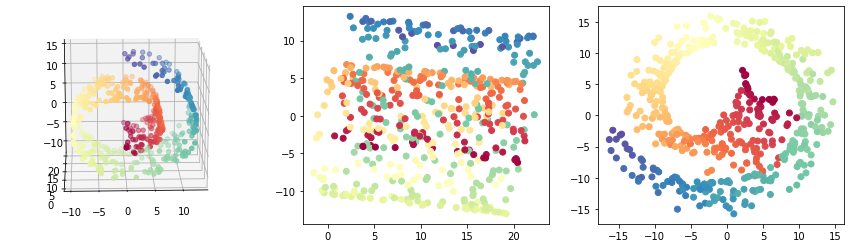

In [5]:
plot_nonlinear(n_points2,n_components)

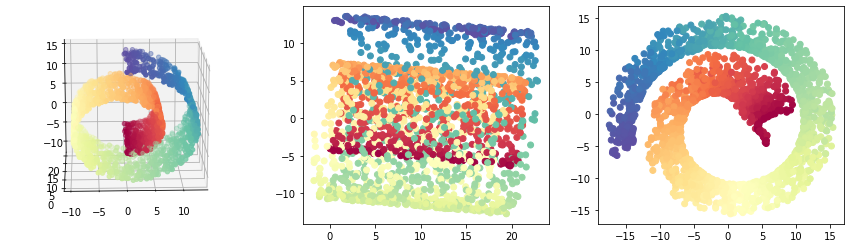

In [6]:
plot_nonlinear(n_points3,n_components)

**Rappel MDS**: 
- Méthode qui permet à partir d'une matrice de **distance** d'obtenir une réduction de dimension,
- L'idée centrale est de préserver la distance entre deux points en dimension réduite:

$$
d_{?}(x_i,x_j) \approx d_{2}(z_i,z_j)
$$

**Problème**: on a utilisé la distance euclidienne. Hors elle n'est pas adaptée à la **description de variété**.

## Géodésique

**Variété différentielle**: on peut voir ca comme une généralisation des courbes et surfaces en dimension $>2$ localement euclidienne. Il s'agit d'espace topologique, de dimension $n$, qui en tout point admet un voinisage homoéomorphe à un ouvert de $\mathbb{R}^n$.

**Exemple**: Variété de dimension 2: surface de sphère/surface de tore.

**Variété Riemannienne**: Variété différentielle muni d'une métrique Riemannienne (on ne détaillera pas).

On peut definir des courbes paramétrées entre deux éléments de la variété $\mathcal{M}$. Une courbe paramètrique entre deux points $x$ et $y$ peut écrit comme:

$$
\gamma(t) :[0,1]\rightarrow \mathcal{M}, \mbox{ avec } \gamma(0)=x, \quad \gamma(1)=y
$$

On peut aussi définir la longueur de cette courbe paramétrée:

$$
L(\gamma)=\int_0^t \parallel \gamma^{'}(t)\parallel_g dt
$$

avec $\parallel .\parallel_g$ une norme issue de la métrique Riemannienne.

**Distance géodésique**:

$$
d_G(x,y)= \inf_{\gamma(0)=x,\gamma(1)=y}L(\gamma)
$$

Il s'agit donc chercher la courbe paramétrée de longueur (donc d'énergie) minimale.

In [23]:
def plot_voisin():
    t= np.linspace(0,1,200)
    ft = np.sqrt(t) * 1440 * (4*np.pi)/360
    dtx = -np.cos(ft)*ft 
    dty = np.sin(ft)*ft 

    px=[dtx[35]]
    py=[dty[35]]
    nx_geo=[dtx[33],dtx[34],dtx[35],dtx[36],dtx[37]]
    ny_geo=[dty[33],dty[34],dty[35],dty[36],dty[37]]

    nx_eucl=[dtx[18],dtx[34],dtx[35],dtx[36],dtx[59]]
    ny_eucl=[dty[18],dty[34],dty[35],dty[36],dty[59]]

    t2= np.linspace(0,1,25)
    dtx2 = t2*10 
    dty2 = 2*t2*10+4

    px2=[dtx2[15]]
    py2=[dty2[15]]
    nx_geo2=[dtx2[13],dtx2[14],dtx2[15],dtx2[16],dtx2[17]]
    ny_geo2=[dty2[13],dty2[14],dty2[15],dty2[16],dty2[17]]

    nx_eucl2=[dtx2[13],dtx2[14],dtx2[15],dtx2[16],dtx2[17]]
    ny_eucl2=[dty2[13],dty2[14],dty2[15],dty2[16],dty2[17]]

    plt.figure(figsize=(14,8))
    ax= plt.subplot(221)
    ax.plot(dtx,dty,c='black')
    ax.scatter(dtx, dty, marker='o', c = 'black',s=20)
    ax.scatter(px,py,marker='o',s=80, c='b')
    ax.scatter(nx_geo,ny_geo,marker='o',s=40, c='r')

    ax2= plt.subplot(222)
    ax2.plot(dtx,dty,c='black')
    ax2.scatter(dtx, dty, marker='o', c = 'black',s=20)
    ax2.scatter(px,py,marker='o',s=80, c='b')
    ax2.scatter(nx_eucl,ny_eucl,marker='o',s=40, c='r')

    ax3= plt.subplot(223)
    ax3.plot(dtx2,dty2,c='black')
    ax3.scatter(dtx2, dty2, marker='o', c = 'black',s=20)
    ax3.scatter(px2,py2,marker='o',s=80, c='b')
    ax3.scatter(nx_geo2,ny_geo2,marker='o',s=40, c='r')

    ax4= plt.subplot(224)
    ax4.plot(dtx2,dty2,c='black')
    ax4.scatter(dtx2, dty2, marker='o', c = 'black',s=20)
    ax4.scatter(px2,py2,marker='o',s=80, c='b')
    ax4.scatter(nx_eucl2,ny_eucl2,marker='o',s=40, c='r')


**Exemple de Géodésique**:

- [Cas du Tore](http://www.rdrop.com/~half/math/torus/geodesics.xhtml)

Notion de voisinage selon la distance utilisée (gauche: géodésique, droite: euclidienne):


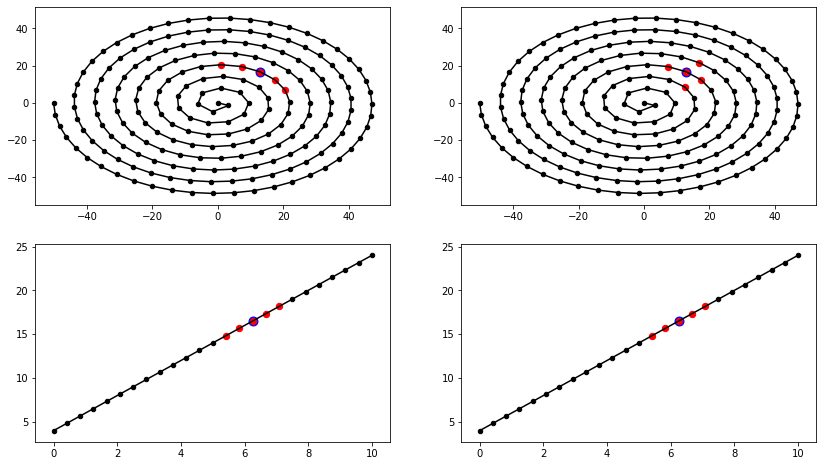

In [24]:
plot_voisin()

**Idée de la méthode ISOMAP**: 
- on calcul une matrice des distances géodésiques entre les points
- on applique la méthode MDS

**Question**: comment calculer la géodésique ? peut t'on appliquer MDS tout le temps ?

## Coeur de la méthode ISOMAP

**Calcul de la géodésique**:

- on crée le graphe de K-plus proche voisin. Cela consiste à connecter par une arrête un point à ses K voisins de distance (euclidienne) minimal.
- on calcul les distances (au sens du graphe) entre deux points à l'aide de la notion de distance sur graphe: **le plus court chemin**

Soit $G=[V,A]$ un graphe.  On définit un chemin entre deux noeuds $x$ et $y$ par:

$$
\gamma(x,y) = ((x,z_1),(z_1,z_2),...,(z_n,y))
$$

une succéssion d'arêtes qui relie les deux points. On définit la distance du plus court chemin par 

$$
dis(x,y) = \operatorname{min}_{\gamma} \mid \gamma \mid 
$$
avec $\mid \gamma \mid$. La longueur du chemin = nombre d'arête dans le cas non-pondéré, la somme des poids sur les arêtes du chemin dans le cas pondéré.


In [22]:
def plot_manifold():#  Reft data set
    t= np.linspace(0,1,1000)
    ft = np.sqrt(t) * 1440 * (2*np.pi)/360
    dtx = -np.cos(ft)*ft 
    dty = np.sin(ft)*ft 

    px=[dtx[90],dtx[980]]
    py=[dty[90],dty[980]]
    dtx_d = np.array(dtx[90:980])
    dty_d = np.array(dty[90:980])

    plt.figure(figsize=(6,5))
    plt.plot(dtx, dty, c = 'black')
    plt.scatter(px,py,marker='o',s=50, c='b')
    plt.plot(dtx_d, dty_d, c = 'red')
    plt.title('Exemple Variété et géodésique')
    return px,py

**Qu'est ce que sait que cette distance** ? On va regarder numériquement.

On se donne une variété 1D.

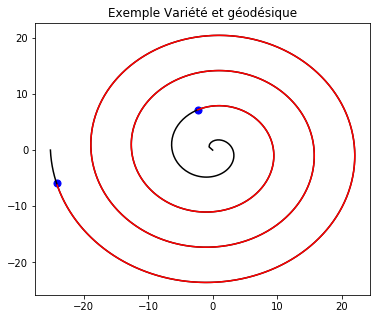

In [23]:
px,py=plot_manifold()

In [24]:
def plot_data_set(px,py): 
    ns = np.sqrt(np.random.rand(100,1)) * 1440 * (2*np.pi)/360
    d1xs = -np.cos(ns)*ns + np.random.rand(100,1) * 0.8
    d1ys = np.sin(ns)*ns + np.random.rand(100,1) * 0.8

    d1xs[2]=px[0]; d1ys[2]=py[0]
    d1xs[85]=px[1]; d1ys[85]=py[1]

    nl = np.sqrt(np.random.rand(1000,1)) * 1440 * (2*np.pi)/360
    d1xl = -np.cos(nl)*nl + np.random.rand(1000,1) * 0.8
    d1yl = np.sin(nl)*nl + np.random.rand(1000,1) * 0.8

    d1xl[5]=px[0]; d1yl[5]=py[0]
    d1xl[450]=px[1]; d1yl[450]=py[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    ax1.scatter(d1xs, d1ys, c = 'black', s=40)
    ax1.scatter(d1xs[2],d1ys[2],marker='o',s=50,c='b')
    ax1.scatter(d1xs[85],d1ys[85],marker='o',s=50,c='b')
    Xs = np.hstack((d1xs,d1ys));


    ax2.scatter(d1xl, d1yl, c = 'black', s=30)
    ax2.scatter(d1xl[5],d1yl[5],marker='o',s=60,c='b')
    ax2.scatter(d1xl[450],d1yl[450],marker='o',s=60,c='b')
    Xl = np.hstack((d1xl,d1yl));
    return Xs,d1xs,Xl,d1xl

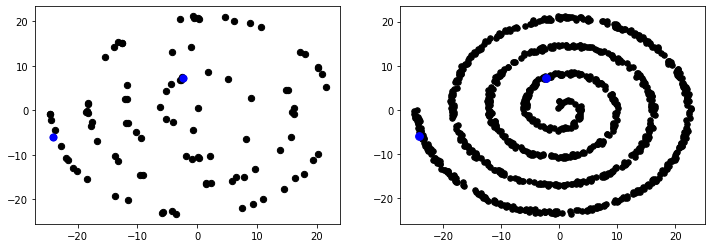

In [25]:
Xs,d1xs,Xl,d1xl= plot_data_set(px,py)

In [26]:
def graph(X,d1x,size,nn):
    As2 = kneighbors_graph(X, nn, include_self=True)
    As2 = 0.5 * (As2 + As2.T) # symetric part)
    Gs2 = nx.Graph()

    for i in range(0,size):
        Gs2.add_node(i,pos=[d1x[i],d1x[i]])
    
    for i in range(0,size):
        for j in range(0,size):
            if As2[i,j]>0:
                Gs2.add_edge(i,j, weight=As2[i,j])   
                
    return Gs2

In [27]:
def plot_graph(X,d1x,size,n1,n2,n3,ibegin,ifin,geo):
    gs_1= graph(X,d1x,size,n1)
    gs_2= graph(X,d1x,size,n2)
    gs_3= graph(X,d1x,size,n3)
    if geo== True:
        distSh1 = nx.shortest_path(gs_1, source=ibegin, target=ifin)
        distSh2 = nx.shortest_path(gs_2, source=ibegin, target=ifin)
        distSh3 = nx.shortest_path(gs_3, source=ibegin, target=ifin)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
    
    for i in range(size):
        neighbors1=list(nx.all_neighbors(gs_1,i))
        neighbors2=list(nx.all_neighbors(gs_2,i))
        neighbors3=list(nx.all_neighbors(gs_3,i))
        for j in range(len(neighbors1)):  
             ax1.plot(X[[i,neighbors1[j]], 0], X[[i,neighbors1[j]], 1], c='gray')
        for j in range(len(neighbors2)):  
             ax2.plot(X[[i,neighbors2[j]], 0], X[[i,neighbors2[j]], 1], c='gray')
        for j in range(len(neighbors3)):  
             ax3.plot(X[[i,neighbors3[j]], 0], X[[i,neighbors3[j]], 1], c='gray')
        
    ax1.scatter(X[:,0], X[:,1], c='black', s=60)
    ax1.scatter(X[ibegin,0],X[ibegin,1],marker='o',s=50,c='b')
    ax1.scatter(X[ifin,0],X[ifin,1],marker='o',s=50,c='b')

    ax2.scatter(X[:,0], X[:,1], c='black', s=60)
    ax2.scatter(X[ibegin,0],X[ibegin,1],marker='o',s=50,c='b')
    ax2.scatter(X[ifin,0],X[ifin,1],marker='o',s=50,c='b')

    ax3.scatter(X[:,0], X[:,1], c='black', s=60)
    ax3.scatter(X[ibegin,0],X[ibegin,1],marker='o',s=50,c='b')
    ax3.scatter(X[ifin,0],X[ifin,1],marker='o',s=50,c='b')
    if geo==True:
    
        for i in range(len(distSh1)-1):
            j = distSh1[i] 
            jp = distSh1[i+1] 
            ax1.plot(X[[j,jp],0], X[[j,jp],1], c='red')

        for i in range(len(distSh2)-1):
            j = distSh2[i] 
            jp = distSh2[i+1] 
            ax2.plot(X[[j,jp],0], X[[j,jp],1], c='red')
     
        for i in range(len(distSh3)-1):
            j = distSh3[i] 
            jp = distSh3[i+1] 
            ax3.plot(X[[j,jp],0], X[[j,jp],1], c='red')

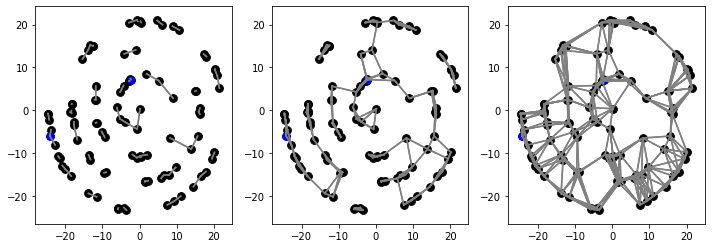

In [28]:
plot_graph(Xs,d1xs,100,2,4,8,2,85,False)

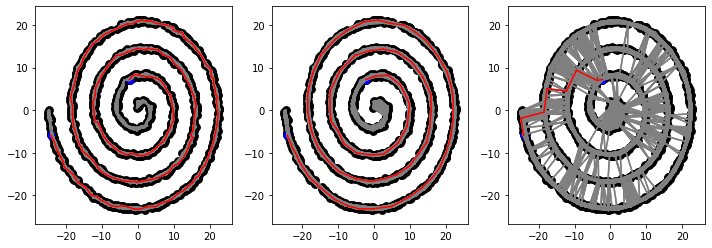

In [31]:
plot_graph(Xl,d1xl,1000,10,25,35,5,450,True)

**Conclusion**: on voit que dans les derniers exemples le **graphe capture la variété** et donc que **le plus court chemin correspond à la distance géodésique**

On a donc un algo de calcul des distance géodisiques. Quand est ce que cela marche ? On voit qu'il faut:
- suffisamment de points,
- suffisamment de voisins dans l'algorithme de graphe mais pas trop.

Peut t'on avoir des résultats théoriques sur cette approximation de la distance géodésique ?

**Resultats théorique**:
- On pose $d_{\mathcal{M}}(.,.)$ la distance géodésique sur la variété,
- On pose $d_G(.,.)$ la distance du plus court chemin sur le graphe:

$$
d_G(x,y)=\operatorname{min}_{(x=z_1,z_2,..,y=z_n)}(d_2(z_1,z_2),....,d_2(z_1,z_n))
$$

On minimise sur l'ensemble des chemins possibles sur le graphe.

- On pose $d_S(.,.)$ la distance géodésique sur le graphe:

$$
d_S(x,y)=\operatorname{min}_{(x=z_1,z_2,..,y=z_n)}(d_{\mathcal{M}}(z_1,z_2),....,d_{\mathcal{M}}(z_1,z_n))
$$


Principe de la preuve:
- on montre que $\lambda_1 d_{\mathcal{M}}(x,y)\leq d_{\mathcal{S}}(x,y) \leq \lambda_2 d_{\mathcal{M}}(x,y)$
- on montre que $\lambda_3 d_{\mathcal{}}(x,y)\leq d_{\mathcal{G}}(x,y) \leq \lambda_4 d_{\mathcal{S}}(x,y)$

On se donne $\mathcal{M}$ une sous variété de $\mathbb{R}^d$ et $V=[x_1,...x_n]$ un échantillon. On se donne le graphe $G=[V,W]$. On se donne deux réels positifs $0<\lambda_1\leq 1$, $0 <\lambda_2\leq 1$.

**Hypothèses**:
- **variété**: convexe au sens de la distance géodésique
- **Echantillonnage**:  pour tout points de $x\in \mathcal{M}$ il existe $i\leq n$ tel que

$$
d_{\mathcal{M}}(x,x_i)\leq \delta
$$

- **Graphe 1** toute les arêtes $(x,y)$ tel que $d_2(x,y)\leq \epsilon_{min}$ sont contenu dans le graphe,
- **Graphe 2** toute les arêtes du graphe satisfont $d_2(x,y)\leq \epsilon_{max}$.

**Remarque**: la seconde hypothèse dit qu'il faut suffisamment de points. Les deux dernières sont réliées au graphe de plus proche voisins. Des théorèmes existent pour relier ces hypothèses à l'hyperparamètre $K$. **On peut déterminer un K satisfaisant ces hypothèses**.

**Théorème**:
Si $\epsilon_{max} \leq C(\lambda_1,\mathcal{M})$ (je ne détaille pas) et si $\delta \leq \frac{\lambda_2\epsilon_{min}}{4}$ (relie l'échantillonnage et le calcul du graphe) alors

$$
(1-\lambda_1) \leq \frac{d_{G}(x,y)}{d_{\mathcal{M}}(x,y)} \leq (1+\lambda_2)
$$

**Problème potentiel**:

- EN MDS on tranforme la matrice des distances $D$ en matrice de Gram $G$ définie positive.
- Toujours vrai pour la distance euclidienne. Cas de la **distance géodésique** ?

Dans le cas ou il n'y a pas assez de points on peut perdre le coté positive de la transformation de $D$. On peut ajouter des corrections assurant ce point. Voir: *Geometric Structure of High-Dimensional
Data and Dimensionality Reduction* de Jianzhong Wang.

## Résultats

In [32]:
n_points2 = 500
n_points3 =2000

n_components = 2

def plot_nonlinear2(n_points,n_components):
    X, color = datasets.make_swiss_roll(n_points, noise=0.05)

    # Create figure
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(16, -92)

    embedding_mds = manifold.MDS(n_components=2,n_init=1)
    Y_mds = embedding_mds.fit_transform(X)
    ax2 = fig.add_subplot(1, 3,2)
    ax2.scatter(Y_mds[:, 0], Y_mds[:, 1], c=color, cmap=plt.cm.Spectral)
    
    isomap = Isomap(n_components=2)
    Y_isomap= isomap.fit_transform(X)
    ax1 = fig.add_subplot(1, 3,3)
    ax1.scatter(Y_isomap[:, 0], Y_isomap[:, 1], c=color, cmap=plt.cm.Spectral)

Exemple:
- Problème 3D, projection 2D PCA, projection 2D MDS. 500 points puis 2000 points

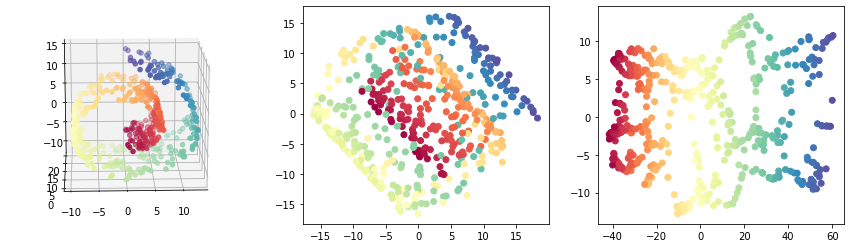

In [34]:
plot_nonlinear2(n_points2,2)

In [35]:
plot_nonlinear2(n_points3,2)

In [36]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 35

# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

# ----------------------------------------------------------------------
# Plot images of the digits
def plot_digits():
    n_img_per_row = 20
    img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
    for i in range(n_img_per_row):
        ix = 10 * i + 1
        for j in range(n_img_per_row):
            iy = 10 * j + 1
            img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

    plt.imshow(img, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title('A selection from the 64-dimensional digits dataset')

# ----------------------------------------------------------------------
# Projection on to the first 2 principal components

t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)

# ----------------------------------------------------------------------
# Isomap projection of the digits dataset
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)

# ----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)

**Application aux images de chiffres**

In [37]:
plot_digits()

In [38]:
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

In [39]:
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))


Done. Stress: 139432064.183075


Done.


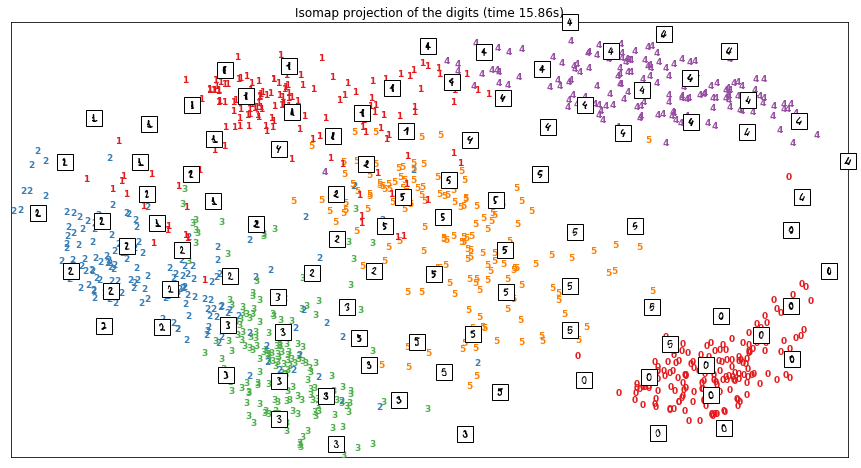

In [40]:
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

**Conclusion**:
- La méthode ISOMAP permet de déplier la variété et de construire une réduction qui préserve les voisinages au sens de la variété.
- Méthode très couteuse car il faut calculer le plus court chemin entre chaque points.
- Comme d'autres méthodes (voir exposé de Emmanuel) elle utilise des outils de géométrie différentielle.

**Bilan 2020-2021**

- Introduction aux méthodes d'apprentissage supervisé: régression et régularisation, SVM, arbre décision, forêt aléatoire.
- Introduction aux méthodes d'apprentissage profond: MPC, CNN, Réseau à Noyau, PINNS et réseau de Fourier pour les EDP, rétro-propagagtion et explosion de gradient.
- Introduction aux méthodes d'apprentissage non supervisé: PCA, Kernel PCA, MDS, ISOMAP et eigenmaps (réduction de dimension), K-moyennes, mélange Gaussien (Clustering).
- Code: Sk-learn et Keras.

**Quoi en 2021-2022  ?**
- Encore un peu d'apprentissage machine, pas mal d'apprentissage profond et des applications
- sous forme de cycle ? format ? 1 par semaine, 2 toutes les deux semaines ?

Possibles cycles:
- **Clustering et apprentissage de dictionnaire**: (K-SVD, Matching Pursuit, clustering spectral, mean-shift, hierarchique, DBScan)
- **Apprentissage Bayesien**: regression linéaire et à noyau, classification, lien avec les processus Gaussien, réseaux bayesien.
- **Réseau de neurones récurrent**: Réseau de base et GRU, LTSM
- **Estimation de densité**: Méthode des Noyaux, autres ?, réseau récurrent à densité

Possibles cycles plus avancés:
- **réduction de dimension**: LLE,t-SNE, LTSA, auto encoder, auto encoder debruiteur et sparse
- **Modèles génératifs**: VAE, GAN et variantes, normalized flows, Modéles d'énergie
- **traitement du langage**: mécanisme d'attention, transformer

- **Apprentissage profond Géométrique**: Réseau convolutif sur graphe, réseau récurrent et auto encodeur sur graphe, DeepSet, théorie de APG
- **Apprentissage et équations différentielles**: PINNS avancés, PDEnet, DeepOnet et variante variationnelle. réseau a pronfondeur infini lien avec les ODE/EDP. ODenet et variantes.
- **Théorie**: théorie PAC pour l'apprentissage, Approximation universelle des MPC etc.